In [1]:
import os
import sys

spark_home = os.environ.get('SPARK_HOME', None)
print(spark_home)
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

src_dir = os.environ.get('SRC_DIR', None)
if not src_dir:
    print('SRC_DIR must be set to the src directory in the git project')
    sys.exit(1)
class_path = os.path.join(src_dir, 'PtAgg.py')
sys.argv = ['python/pyspark/shell.py', '--py-files', class_path]

execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

/Users/davidada/apps/spark-1.4.1-bin-hadoop2.6
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.4.1
      /_/

Using Python version 2.7.10 (default, Oct 23 2015 19:19:21)
SparkContext available as sc, HiveContext available as sqlContext.


/Users/davidada/dev/MH/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


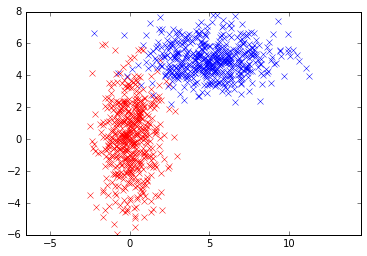

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000111)
class_one_size = 500
class_two_size = 500
mean = [0, 0]
cov = [[1, 0], [0, 5]]
class_one = np.random.multivariate_normal(mean, cov, class_one_size)
x, y = class_one.T
mean2 = [5, 5]
cov2 = [[5, 0], [0, 1]]
class_two = np.random.multivariate_normal(mean2, cov2, class_two_size)
x2, y2 = class_two.T
plt.plot(x, y, 'x', color='red')
plt.plot(x2, y2, 'x', color='blue')
plt.axis('equal')
plt.show()
both_classes = np.concatenate((class_one, class_two), axis=0)

np.set_printoptions(suppress=True)
np.savetxt('binary_sim_data_{0}_{1}.csv'.format(class_one_size, class_two_size), both_classes, fmt='%5.4f,%5.4f',
           header="x,y")

new centers: 0.0372730787772,-1.29334795317 6.57695784414,5.00301765877
new centers: 0.0254609218437,0.0791138276553,1 5.08251636727,5.00102235529,1
new centers: 0.0244618473896,0.0698805220884,1 5.07343366534,5.00037749004,1
final centers: 0.0244618473896,0.0698805220884,1 5.07343366534,5.00037749004,1


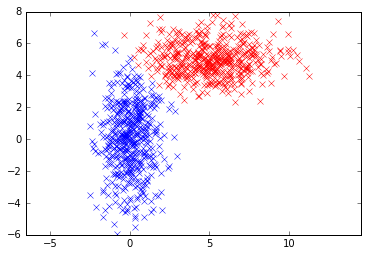

In [26]:
import copy
import math
import sys

from PtAgg import PtAgg

# I originally wrote this without classes and it was a pretty confusing to follow.
# So, I created a PtAgg class that has an x,y location and a counter (because we
# also need to 'add' points together).

def convert_binary_line(line):
    assert len(line) == 2
    return (float(line[0]), float(line[1]))


def pick_closest_center(p, centers):
    d_min = sys.float_info.max
    idx_min = -1
    for idx in range(len(centers)):
        c = centers[idx]
        d = p.DistSqr(c)
        if d < d_min:
            d_min = d
            idx_min = idx
    assert idx_min != -1
    # Make an empty array of center points, then only add to the closest center point.
    closest_centers = [PtAgg() for x in centers]
    closest_centers[idx_min] = p
    return closest_centers


def center_reduce(a, b):
    # Combine the lists of center point accumulations.
    return tuple([el1 + el2 for el1, el2 in zip(a, b)])


def random_point_location():
    return PtAgg(np.random.uniform(min_max[0], min_max[1]),
                 np.random.uniform(min_max[2], min_max[3]))

#np.random.seed(1000111)
NUM_CLUSTERS = 2


input_rdd = sc.textFile('binary_sim_data_{0}_{1}.csv'.format(class_one_size, class_two_size))
header = input_rdd.first() # Remove the first line.
parsed_input_rdd = input_rdd.filter(lambda x: x !=header).map(
    lambda x: convert_binary_line(x.split(',')))


# Find (x_min, x_max, y_min, y_max) over all data; We'll use that as the bounds for our centers.
# We start by saying that each point's x and y are the largest and smallest x's and y's they've seen.
# Next, we compare x,y points via reduce and keep smaller x (and y) and the larger x (and y). 
#
# Note that don't use our class yet -- as it's not actually helpful here.
min_max = parsed_input_rdd.map(lambda p: (p[0],p[0],p[1],p[1])).reduce(
    lambda p1,p2: (min(p1[0],p2[0]), max(p1[1],p2[1]), min(p1[2], p2[2]), max(p1[3], p2[3])))

# Pick a random start location for every cluster center
c_centers = [random_point_location() for x in range(NUM_CLUSTERS)]

# Side note: pt_rdd would be a good thing to cache.
pt_rdd = parsed_input_rdd.map(lambda x: PtAgg(x[0], x[1], 1))
MAX_STEPS = 100
MIN_DELTA = 0.001
delta = 1.0
step = 0
while delta > MIN_DELTA and step < MAX_STEPS:
    step += 1
    c_centers_old = copy.deepcopy(c_centers)
    b_c_centers = sc.broadcast(c_centers_old)
    s = ' '.join([str(x) for x in b_c_centers.value])
    print('new centers: {0}'.format(s))
    # For every point, find the cluster it's closer to and add to its total x, y, and count
    # Let the reader note that for large inputs (many partitions) it may make sense to
    # replace reduce with treeReduce to lessen the burden on the master.
    totals = pt_rdd.map(lambda x: pick_closest_center(x, b_c_centers.value)).reduce(
        lambda a,b: center_reduce(a,b))
    # Now update the location of the centers as the mean of all of the points closest to it
    # (unless there are none, in which case pick a new random spot).
    c_centers = [t.Normalize() if t.cnt != 0 else random_point_location() for t in totals]
    
    # compute the distance that each cluster center moves, the set the max of those as
    # the delta used to the stop condition.
    deltas = [math.sqrt(c.DistSqr(c_old)) for c, c_old in zip(c_centers, c_centers_old)]
    delta = max(deltas)
        
s = ' '.join([str(x) for x in c_centers])
print('final centers: {0}'.format(s))
c_centers_old = copy.deepcopy(c_centers)
b_c_centers = sc.broadcast(c_centers_old)

# Now, take the centers and use them to label all of the points.
possible_colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
pt_labeled = pt_rdd.map(lambda x: pick_closest_center(x, b_c_centers.value))
for c_idx in range(NUM_CLUSTERS):
    labeled_pts = pt_labeled.map(lambda x: x[c_idx]).filter(
        lambda a: abs(a.x) > sys.float_info.min or abs(a.y) > sys.float_info.min).collect()
    pts_x = [pt.x for pt in labeled_pts]
    pts_y = [pt.y for pt in labeled_pts]

    plt.plot(np.array(pts_x), np.array(pts_y), 'x', color=possible_colors[c_idx])
plt.axis('equal')
plt.show()


[array([ 0.02446185,  0.06988052]), array([ 5.07343367,  5.00037749])]


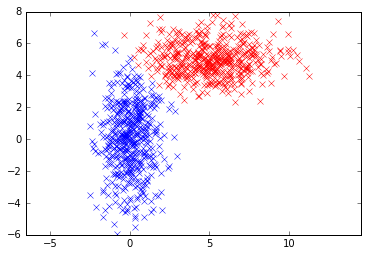

In [40]:
# Or we could just do it using mllib
# Code modified from: http://spark.apache.org/docs/latest/mllib-clustering.html#k-means
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

def matchCluter(clusters, pt, cluster_center):
    pt_center = clusters.centers[clusters.predict(pt)]
    for idx in range(len(pt_center)):
        if pt_center[idx] != cluster_center[idx]:
            return False
    return True

# Load and parse the data
input_rdd = sc.textFile('binary_sim_data_{0}_{1}.csv'.format(class_one_size, class_two_size))
header = input_rdd.first() # Remove the first line.
data = input_rdd.filter(lambda x: x != header)

parsedData = data.map(lambda line: np.array([float(x) for x in line.split(',')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, NUM_CLUSTERS, maxIterations=10,
        runs=10, initializationMode="random")
print(clusters.clusterCenters)
for c_idx in range(NUM_CLUSTERS):
    c_center = clusters.clusterCenters[c_idx]
    labeled_pts = parsedData.filter(lambda x: matchCluter(clusters, x, c_center)).collect()
    pts_x = [pt[0] for pt in labeled_pts]
    pts_y = [pt[1] for pt in labeled_pts]

    plt.plot(np.array(pts_x), np.array(pts_y), 'x', color=possible_colors[c_idx])
plt.axis('equal')
plt.show()